In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bacteria(params, u):
    a, b, g, u_thresh, n = params
    return a + ((b * np.power(u, n)) / (np.power(u_thresh, n) + np.power(u, n))) - (g * u)

In [3]:
def bacteria_particle(params, u, cells):
    du_b = (bacteria(params, u)) * cells
    return du_b

In [4]:
def plot_state(x, y, z1, z2, count, save):
    plt.figure(figsize=(12, 4))
    titles=['u','cells']
    for idx, z in enumerate([z1, z2]):
        plt.subplot(1, 2, idx+1)
        plt.scatter(x, y, c=z, s=15)
        plt.title(titles[idx], size=15)
        plt.colorbar()
    if save == 'save':
        plt.savefig('out_' + str(count) + '.png')
    else:
        plt.show()
    return

In [5]:
def verlet(x, y, r, e):
    neighbors = np.zeros((50, 50), dtype = 'object')
    kernel = np.zeros((50, 50), dtype = 'object')
    dim = np.shape(x)
    for i in range(dim[0]):
        for j in range(dim[1]):
            dist = np.sqrt(np.square(x[i,j] - x) + np.square(y[i,j] - y))
            neighbors[i, j] = np.transpose(np.where(dist <= r))
            kernel[i, j] = (1 / (4 * (np.pi * np.square(e)))) * np.exp(-(np.square(dist[dist <= r]) / (4 * np.square(e))))
    return neighbors, kernel

In [6]:
def pse(nest, D, Vp, ge, e):
    k_sum = np.zeros((50, 50))
    dim = np.shape(nest)
    for i in range(dim[1]):
        for j in range(dim[2]):
            k_sum[i, j] = np.sum((np.array([nest[2][k[0], k[1]] for k in nest[4][i, j]]) - nest[2][i, j]) * nest[5][i, j]) 
    du_diff = k_sum * Vp * D / np.square(e)
    du_deg = -ge * nest[2]
    return du_diff + du_deg

In [23]:
def draw_cell(cells, x, y, center, radius, u, D, level):
    dim = np.shape(cells)
    border = cells
    for i in range(dim[0]):
        for j in range(dim[1]):
            dist = np.square(x[i, j] - center[0]) + np.square(y[i, j] - center[1])
            if dist < np.square(radius):
                cells[i, j] = 2
                u[i, j] = level
                D[i, j] = 0.5
    return cells, u, D

In [21]:
params=np.array([0, 10, 0.1, 10, 10])           # rxn paramerters: a, b, g, u_thresh, n
D = np.ones((50, 50))                           # diffusion coefficient of ue
ge = 0                                          # external degradation of AHL
T = 500                                         # max time
h = 1                                           # particle spacing
Vp = h ** 2
dt = (h ** 2)/(4 * D[0,0])                      # time step
e = h                                           # kernel width
r = np.sqrt(2)                                  # radius of interaction
particles = np.arange(0+(h/2),51-(h/2),h)       # create mesh of particles
x, y = np.meshgrid(particles, particles)
u = np.zeros((50, 50))                          # initial concentrations
cells = np.zeros((50, 50))                      # bacterium count in each particle

cells, u, D = draw_cell(cells, x, y, [24, 24], 5, u, D, 10)
cells, u, D = draw_cell(cells, x, y, [36, 37], 3, u, D, 0)
cells, u, D = draw_cell(cells, x, y, [20, 33], 3, u, D, 0)
cells, u, D = draw_cell(cells, x, y, [40, 10], 3, u, D, 0)
cells, u, D = draw_cell(cells, x, y, [15, 15], 6, u, D, 0)

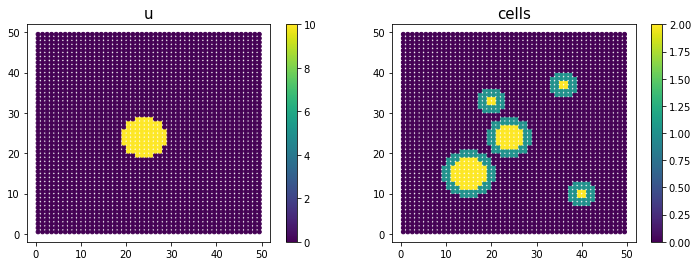

In [22]:
neighbors, kernel = verlet(x, y, r, e)                     # get neighbor and kernel array
nest=np.array([x, y, u, cells, neighbors, kernel])    # compile verlet list
plot_state(nest[0], nest[1], nest[2], nest[3], 0, 'show')

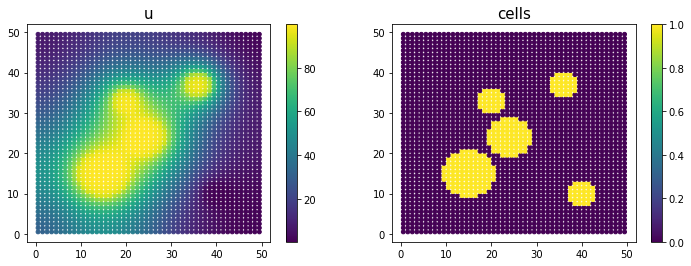

In [10]:
t = 0
count = 0
while t < T:
    du_e = pse(nest, D, Vp, ge, e) * dt
    du_b = bacteria_particle(params, nest[2], nest[3])
    du_b = du_b * dt
    nest[2] = nest[2] + du_b +du_e
    #if count % 20 == 0:
    #    plot_state(nest[0], nest[1], nest[2], nest[3], count, 'save')
    t = t + dt
    count = count + 1

plot_state(nest[0], nest[1], nest[2], nest[3], count, 'show')

In [71]:
def draw_cell_membrane(membrane, cells, x, y, center, radius, u, D, level):
    dim = np.shape(cells)
    border = cells
    for i in range(dim[0]):
        for j in range(dim[1]):
            dist = np.square(x[i, j] - center[0]) + np.square(y[i, j] - center[1])
            if dist < np.square(radius-2):
                cells[i, j] = 1
                u[i, j] = level
                D[i, j] = 1
            if dist > np.square(radius-2) and dist < np.square(radius):
                membrane[i, j] = 1
                D[i, j] = 0.5
    return membrane, cells, u, D

In [77]:
params=np.array([0, 10, 0.1, 10, 10])           # rxn paramerters: a, b, g, u_thresh, n
D = np.ones((50, 50))                           # diffusion coefficient of ue
ge = 0                                          # external degradation of AHL
T = 500                                         # max time
h = 1                                           # particle spacing
Vp = h ** 2
dt = (h ** 2)/(4 * D[0,0])                      # time step
e = h                                           # kernel width
r = np.sqrt(2)                                  # radius of interaction
particles = np.arange(0+(h/2),51-(h/2),h)       # create mesh of particles
x, y = np.meshgrid(particles, particles)
u = np.zeros((50, 50))                          # initial concentrations
cells = np.zeros((50, 50))                      # bacterium count in each particle
membrane = np.zeros((50, 50))   
membrane, cells, u, D = draw_cell_membrane(membrane, cells, x, y, [24, 24], 5, u, D, 10)
membrane, cells, u, D = draw_cell_membrane(membrane, cells, x, y, [36, 37], 3, u, D, 0)
membrane, cells, u, D = draw_cell_membrane(membrane, cells, x, y, [20, 33], 3, u, D, 0)
membrane, cells, u, D = draw_cell_membrane(membrane, cells, x, y, [40, 10], 3, u, D, 0)
membrane, cells, u, D = draw_cell_membrane(membrane, cells, x, y, [15, 15], 6, u, D, 0)

In [78]:
def plot_state(x, y, z1, z2, z3, count, save):
    plt.figure(figsize=(12, 4))
    titles=['u','cells']
    for idx, z in enumerate([z1, z3-z2]):
        plt.subplot(1, 2, idx+1)
        plt.scatter(x, y, c=z, s=15)
        plt.title(titles[idx], size=15)
        plt.colorbar()
    if save == 'save':
        plt.savefig('out_' + str(count) + '.png')
    else:
        plt.show()
    return

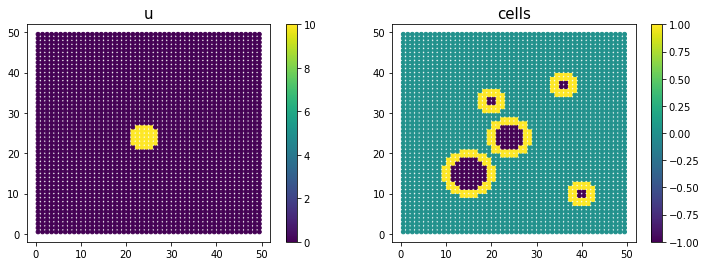

In [79]:
neighbors, kernel = verlet(x, y, r, e)                          # get neighbor and kernel array
nest=np.array([x, y, u, cells, neighbors, kernel, membrane])    # compile verlet list
plot_state(nest[0], nest[1], nest[2], nest[3], nest[6], 0, 'show')

In [80]:
t = 0
count = 0
while t < T:
    du_e = pse(nest, D, Vp, ge, e) * dt
    du_b = bacteria_particle(params, nest[2], nest[3])
    du_b = du_b * dt
    nest[2] = nest[2] + du_b +du_e
    #if count % 20 == 0:
        #plot_state(nest[0], nest[1], nest[2], nest[3], nest[6], count, 'save')
    t = t + dt
    count = count + 1

plot_state(nest[0], nest[1], nest[2], nest[3], nest[6], count, 'show')

/Users/gonzales/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
